# MNIST American Sign Language Alphabet Classification Using CNN

The MNIST database for American Sign Language (ASL) contains images of hand signs for the different letters of the alphabet. Our data comes somewhat preprocessed with the original coloured images being scaled down to 28x28 grayscaled images. The pixels of these images were then converted into their 255 code and then put into a csv. In order to predict and correctly classify signs, we can use convoluted neural networks (CNN).

## Preprocessing

To preprocess the data for use in our CNNs, we first import the data.

In [1]:
### importing relevant libraries ###

import pandas as pd
import numpy as np

In [2]:
### importing data ###

df_train_raw = pd.read_csv('data/sign_mnist_train.csv') # raw train data
df_test_raw = pd.read_csv('data/sign_mnist_test.csv') # raw test data

Now we look at the data to see how it might need to be preprocessed.

In [3]:
### looking at train data ###

df_train_raw.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
### looking at test data ###

df_test_raw.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [5]:
### looking at dataframe shapes ###

train_shape = df_train_raw.shape
test_shape = df_test_raw.shape

print("Train shape is", train_shape, "and test shape is", test_shape)

Train shape is (27455, 785) and test shape is (7172, 785)


We can see that the train and test data have the same features so any preprocessing that we do to one we can do to the other. First we separate the labels since they contain our class information.

In [6]:
### separating labels ###

# labels
df_train_y = df_train_raw['label']
df_test_y = df_test_raw['label']

# dropping labels from original data
df_train_raw_X = df_train_raw.drop('label', axis = 1)
df_test_raw_X = df_test_raw.drop('label', axis = 1)

Now we reshape the features so that it will fit into a CNN and then scale it.

In [7]:
### reshaping and scaling data ###

df_train_X = df_train_raw_X.values.reshape(df_train_raw_X.shape[0], 28, 28, 1) / 255.
df_test_X = df_test_raw_X.values.reshape(df_test_raw_X.shape[0], 28, 28, 1) / 255.

Finally, we have processed data that we can use for our CNN. 

## Exploratory Data Analysis

In our exploratory data analysis (EDA), we check to see how the classes are distributed in the train data. If the train data is skewed towards certain classes, it may be difficult to accurately predict the underrepresented classes since their features might not be accurately extracted.

In [8]:
### importing libraries ###

import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Value Counts of Labels')

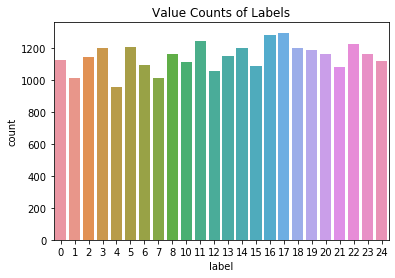

In [9]:
### visualizing labels ###

sns.countplot(x = df_train_y)
plt.title('Value Counts of Labels')

We can see that the classes are relatively well distributed. We can note, however, that there are only 24 classes but the alphabet has 26 letters. This is due to the exclusion of the letters J (class = 9) and Z (class = 25) as they are not static hand gestures. Now let's see what a potential image looks like. 

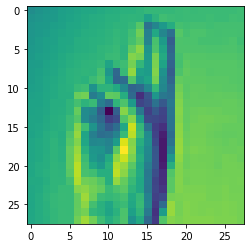

In [10]:
### Visualization of Image ###

plt.imshow(df_train_X[42].reshape(28, 28))

The image can visibly be seen to be the letter U. We can now proceed to modelling.

## Modelling

Now that our preprocessing and EDA are complete, we can use CNNs to model our data.

In [34]:
### import libraries ###

import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, Flatten
from sklearn.metrics import confusion_matrix

First we build our classifier.

In [19]:
### building our CNN classifier ###

def build_classifier():
    
    # classifier
    classifier = Sequential()
    
    # convolution layer and max pooling twice
    classifier.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    
    classifier.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    
    # flattening
    classifier.add(Flatten())
    
    # dense layer
    classifier.add(Dense(128, activation = 'relu'))
    classifier.add(Dropout(0.2)) # dropout
    
    # output layer
    classifier.add(Dense(24, activation = 'softmax'))
    
    # compilation
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return classifier

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 128, epochs = 50)

Now we can use the classifier in a cross validation.

In [22]:
### 5 fold cross validation ###

# cross validation
cross_val = cross_val_score(estimator = classifier,
                           X = df_train_X,
                           y = df_train_y,
                           cv = 5)



Epoch 1/50
21964/21964 [==============================] - 23s 1ms/step - loss: 2.1190 - accuracy: 0.3678
Epoch 2/50
21964/21964 [==============================] - 5s 218us/step - loss: 0.7057 - accuracy: 0.7771
Epoch 3/50
21964/21964 [==============================] - 2s 99us/step - loss: 0.3441 - accuracy: 0.8939
Epoch 4/50
21964/21964 [==============================] - 2s 102us/step - loss: 0.1818 - accuracy: 0.9473
Epoch 5/50
21964/21964 [==============================] - 2s 99us/step - loss: 0.1073 - accuracy: 0.9718
Epoch 6/50
21964/21964 [==============================] - 2s 101us/step - loss: 0.0693 - accuracy: 0.9823
Epoch 7/50
21964/21964 [==============================] - 2s 104us/step - loss: 0.0489 - accuracy: 0.9887
Epoch 8/50
21964/21964 [==============================] - 2s 103us/step - loss: 0.0385 - accuracy: 0.9911
Epoch 9/50
21964/21964 [==============================] - 2s 106us/step - loss: 0.0299 - accuracy: 0.9934
Epoch 10/50
21964/21964 [========================

21964/21964 [==============================] - 2s 112us/step - loss: 1.9600 - accuracy: 0.4305
Epoch 2/50
21964/21964 [==============================] - 3s 115us/step - loss: 0.6277 - accuracy: 0.8002
Epoch 3/50
21964/21964 [==============================] - 2s 104us/step - loss: 0.3048 - accuracy: 0.9053
Epoch 4/50
21964/21964 [==============================] - 2s 106us/step - loss: 0.1637 - accuracy: 0.9523
Epoch 5/50
21964/21964 [==============================] - 3s 115us/step - loss: 0.0946 - accuracy: 0.9769
Epoch 6/50
21964/21964 [==============================] - 2s 110us/step - loss: 0.0629 - accuracy: 0.9849
Epoch 7/50
21964/21964 [==============================] - 3s 116us/step - loss: 0.0399 - accuracy: 0.9916
Epoch 8/50
21964/21964 [==============================] - 3s 119us/step - loss: 0.0323 - accuracy: 0.9926
Epoch 9/50
21964/21964 [==============================] - 3s 118us/step - loss: 0.0243 - accuracy: 0.9947
Epoch 10/50
21964/21964 [==============================] 

In [24]:
### results of cross validation ###

# mean and variance
mean = cross_val.mean()
variance = cross_val.std()

print('The mean of the k fold accuracies is:', mean, 'and the variance is:', variance)

The mean of the k fold accuracies is: 0.9999635815620422 and the variance is: 7.283687591552734e-05


The cross validation shows an extremely high accuracy with low variance which is good. Now we fit the actual model.

In [31]:
### fitting the final model

classifier.fit(df_train_X, df_train_y)

Epoch 1/50
27455/27455 [==============================] - 3s 111us/step - loss: 1.7372 - accuracy: 0.4865
Epoch 2/50
27455/27455 [==============================] - 3s 106us/step - loss: 0.4634 - accuracy: 0.8531
Epoch 3/50
27455/27455 [==============================] - 3s 105us/step - loss: 0.1917 - accuracy: 0.9443
Epoch 4/50
27455/27455 [==============================] - 3s 107us/step - loss: 0.0963 - accuracy: 0.9760
Epoch 5/50
27455/27455 [==============================] - 3s 108us/step - loss: 0.0544 - accuracy: 0.9881
Epoch 6/50
27455/27455 [==============================] - 3s 106us/step - loss: 0.0346 - accuracy: 0.9926
Epoch 7/50
27455/27455 [==============================] - 3s 107us/step - loss: 0.0271 - accuracy: 0.9942
Epoch 8/50
27455/27455 [==============================] - 3s 107us/step - loss: 0.0198 - accuracy: 0.9951
Epoch 9/50
27455/27455 [==============================] - 3s 108us/step - loss: 0.0168 - accuracy: 0.9960
Epoch 10/50
27455/27455 [=====================

In [32]:
### accuracy on train data ###

classifier.score(df_train_X, df_train_y)

27455/27455 [==============================] - 1s 48us/step


0.9999271631240845

In [33]:
### accuracy on test data ###

classifier.score(df_test_X, df_test_y)

7172/7172 [==============================] - 0s 45us/step


0.9177356362342834

The accuracy of the test train data and the test data is quite high. This may be indicative of overfitting but we have performed a cross validation and dropout on the CNN. It may be necessary to lower the number of epochs in a future model. For now, we will look at the confusion matrix and see where the model is going wrong.

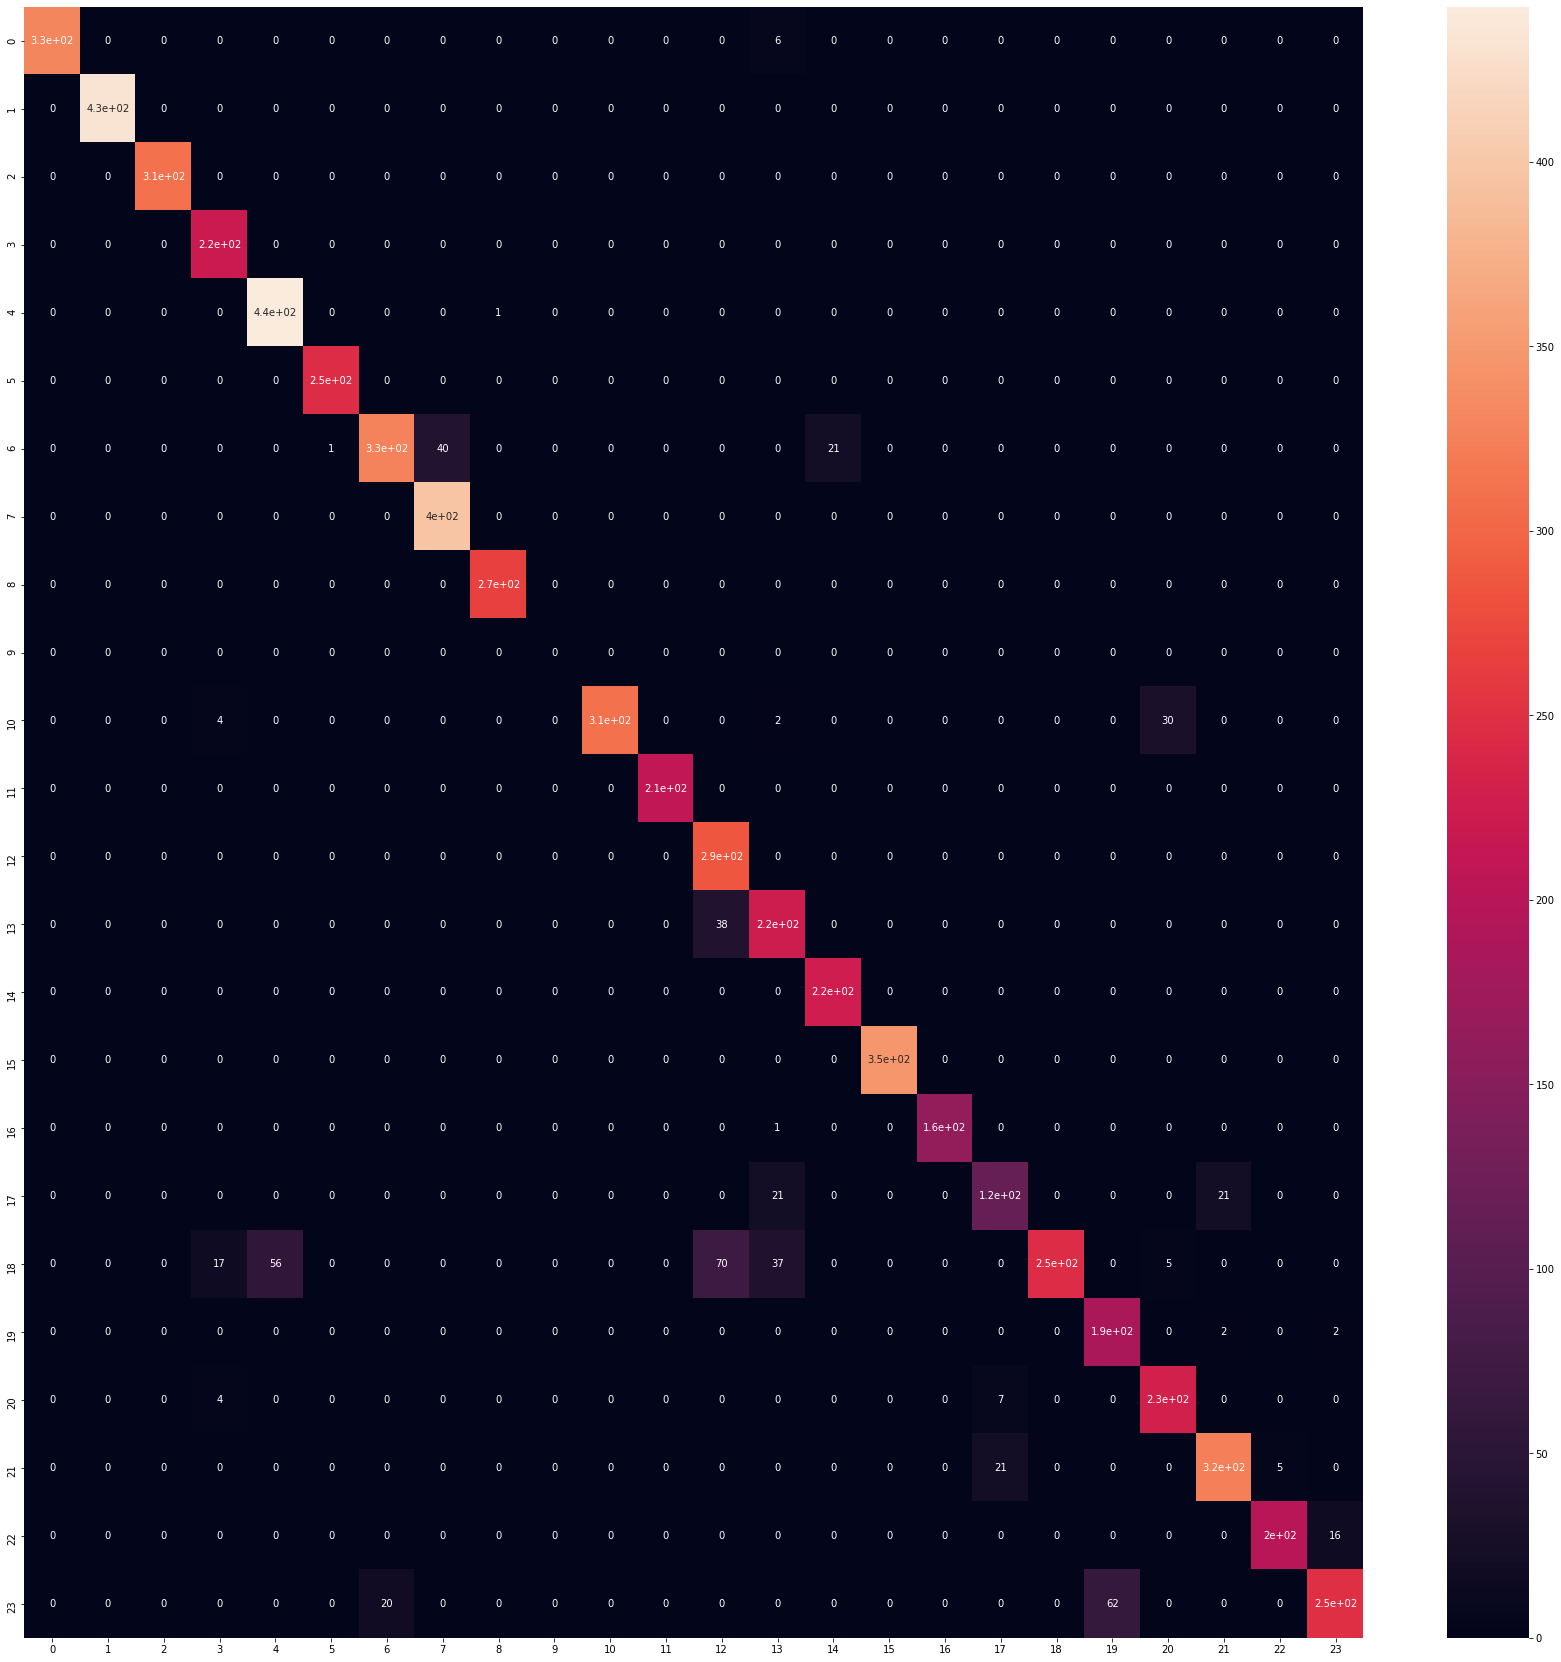

In [46]:
### confusion matrix ###

# predictions
y_pred = classifier.predict(df_test_X)

# confusion matrix
cm = confusion_matrix(y_pred, df_test_y, np.arange(24))

# plotting confusion matrix
plt.figure(figsize = (30, 30))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

In general, we can see that most values are predicted correctly. We can see that class = 9 does not have any representation. It is because class = 9 refers to J which is a dynamic sign and was not taken pictures of. However, its inclusion means that we did not have class = 24 included which is the letter Y, a static sign. The reason for this is because we chose the output layer of the CNN to have 24 neurons and it included the classifier = 9 whereas we assumed it would leave out 9 and 25 (J and Z respectively).

In the confusion matrix, values that have a large amount of false positives are signs that are quite similar. For example, class = 19 (S) is very similar to class = 12 (M). 

## Conclusion

In conclusion, we believe that we have built a good model for the identification of the alphabet in ASL. A lot of the errors come from signs that are very similar to eachother. If we were to improve our model in the future, the following would need to be done: 
* dummy encode the labels so that classifiers that are not represented such as J do not slip into the output layer
* test different epochs with a grid search to see if we are overfitting
* add the dynamic signs, J and Z, and have an image of a point in the sign that is unique